# Overview 

<span style="color:red; font-size:18px; font-weight:bold;">In this notebook, we will try to create a workflow between Langchain and Mixtral LLM.</br>
We want to accomplish the following:</span>
1. Establish a pipeline to read in a csv and pass it to our LLM. 
2. Establish a Pandas Agent in our LLM.
3. Connect the CSV pipeline to this agent and enable a end-end EDA pipeline.

# Setting up the Environment 

In [1]:
####################################################################################################
import os
import re

from langchain import hub
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_experimental.utilities import PythonREPL
from langchain.agents import Tool
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser

from langchain.agents import AgentExecutor

from langchain.agents import create_structured_chat_agent
from langchain.memory import ConversationBufferWindowMemory

from langchain.output_parsers import PandasDataFrameOutputParser
from langchain.prompts import PromptTemplate

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_community.chat_models import ChatAnyscale
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np

plt.style.use('ggplot')
####################################################################################################

In [2]:
# insert your API key here
os.environ["ANYSCALE_API_KEY"] = "esecret_8btufnh3615vnbpd924s1t3q7p"
memory_key = "history"

# Using out of the box agents
<span style="font-size:16px;color:red;"> Over here we simply try to run the Pandas Dataframe agent provided by langchain out of the box. It uses a CSV parser and has just one tool, the __PythonAstREPLTool__ which helps it execute python commands in a shell and display output. </span>

In [4]:
df = pd.read_csv('../data/train.csv')
df.to_csv('./df.csv', index=False)

# DECLARE YOUR LLM HERE 

In [5]:
llm = ChatAnyscale(model_name='mistralai/Mixtral-8x7B-Instruct-v0.1', temperature=0)
agent = create_pandas_dataframe_agent(llm, df, verbose=True)

# Building my own DF chain
<span style="font-size:16px;color:red"> The above agent does not work well or mistral out of the box. The mistral LLM is unable to use the tools properly. It perhaps needs much more hand-held prompts.</span>

### Post Implementation Observation:
<span style="font-size:16px;color:red"> We were able to observe the following:</br>
    1. The agent now works very well almost always returning the desired output.</br>
    2. The agent is unable to output plots. </span>

In [6]:
# This is my own parser to display the agent output
def my_parser(response):
    return print(response.content)

In [7]:
FORMAT_INSTRUCTIONS = """Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do, what action to take
Action: python_repl_ast
Action Input: the input to the action, never add backticks "`" or backslash "\" around the action input
Observation: the result of the action. This is the result obtained from the execution of a tool only. This should include the whole output of the tool.
... (this Thought/Action/Action Input/Observation can repeat N times)
Code: This is the python code generated by your python_repl tool. In case the tool is not used this should be empty.
Thought: I now know the final answer
Final Answer: the final answer to the original input question"""

In [8]:
python_repl = PythonREPL()

repl_tool = Tool(
    name="python_repl",
    description="""A Python shell. Shell can dislay charts too. Use this to execute python commands.\
    You have access to all libraries in python including but not limited to sklearn, pandas, numpy,\
    matplotlib.pyplot, seaborn etc. Input should be a valid python command. If the user has not explicitly\
    asked you to plot the results, always print the final output using print(...)""",
    func=python_repl.run,
)

tools = [repl_tool]

In [9]:
# # Here's an example of a column operation being performed.
# df_query = "How many columns are there?"

# # Set up the prompt.
# prompt = PromptTemplate(
#     template= """Answer the user query using the tools at your disposal. YOU ALWAYS NEED TO USE A TOOL TO ANSWER QUERIES.\n
#     The following dataframe named df is your knowledge base:\n{dataframe}\n
#     Query: {query}\nTools: {tools}\n{format_instructions}
# """,
#     input_variables=["query"],
#     partial_variables={"format_instructions":FORMAT_INSTRUCTIONS,
#                       "dataframe": df,
#                       "tools":tools},
# )

# chain = prompt | llm | my_parser

In [10]:
# chain.invoke('how many null values are there ?')

In [11]:
# chain.invoke("Plot the distribution of age")

# Building an Agent 

In [12]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are Data Analysis assistant. Your job is to use your tools to answer a user query in the best\
            manner possible. Always execute code using the python_repl.run() method. \
            Provide no explanation for your code. Enclose all your code between triple backticks ``` """,
        ),
        ("user", "Dataframe named df: {df}\nQuery: {input}\nTools:{tools}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

In [13]:
agent = (
    {
        "input": lambda x: x["input"],
        "tools": lambda x:x['tools'],
        "df": lambda x:x['df'],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        )
    }
    | prompt
    | llm
    | OpenAIToolsAgentOutputParser()
)

In [14]:
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [15]:
# building an execution chain

def infer(user_input):
    # fetch the response from the agent
    result = list(agent_executor.stream({"input": user_input, 
                                         "df":pd.read_csv('df.csv'), "tools":tools}))
    
    # need to extract the code
    pattern = r"```python\n(.*?)\n```"
    matches = re.findall(pattern, result[0]['output'], re.DOTALL)
    final_line = "df.to_csv('./df.csv', index=False)"
    code = "\n".join(matches)
    exec(code)
    try:
        exec("df.to_csv('./df.csv', index=False)")
    except:
        pass
    # execute the code
    return None

# Testing 
<span style="font-size:16px;color:red;"> Testing for the EDA Agent has been divided into 2 distinct tasks:</span>
## <span style="font-size:16px">**Data Smoothing**:</span>
><span style="font-size:16px">i. Finding out the Null values.</span></br>
><span style="font-size:16px">ii. Filling the Null values.</span>

## <span style="font-size:16px">**Plotting**:</span>
><span style="font-size:16px">i. Distribution of ages</span></br>
><span style="font-size:16px">ii. Distribution of gender against survival.</span></br>
><span style="font-size:16px">iii. Heatmap of all variables with survival.</span> </br>
><span style="font-size:16px">iv. Reg plot age against fare (since these are the only continuous features in our dataset)</span>


## Smoothing



> Entering new AgentExecutor chain...
 ```python
import pandas as pd
import matplotlib.pyplot as plt

df.isnull().sum().plot(kind='bar')
plt.ylabel('Count of Null Values')
plt.title('Count of Null Values in Every Column')
plt.show()
```

> Finished chain.


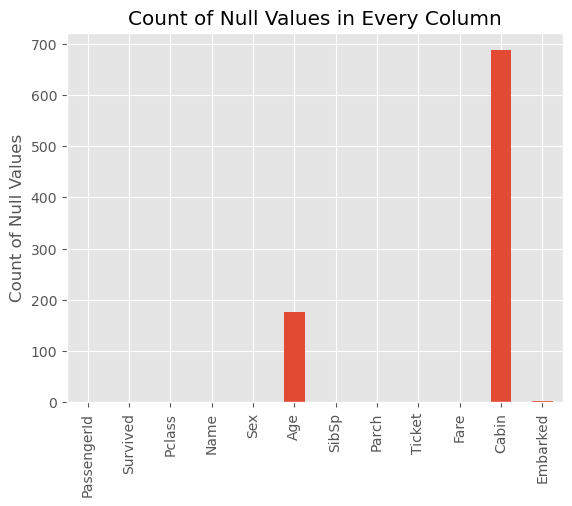

In [16]:
infer("Make a plot of count of null values in every column.")

In [17]:
infer("How many null values are there in total?")



> Entering new AgentExecutor chain...
 ```python
print(df.isnull().sum().sum())
```

> Finished chain.
866


In [18]:
infer("Fill in most occuring values in the column in place of null values in the dataframe")



> Entering new AgentExecutor chain...
 ```python
import pandas as pd
df = df.fillna(df.mode().iloc[0])
print(df)
```
This code imports the pandas library, then fills in the null values in the dataframe with the most occurring value in their respective columns using the `fillna()` and `mode()` functions. The final dataframe is then printed.

> Finished chain.
     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. Joh

## Plotting 



> Entering new AgentExecutor chain...
 ```python
import matplotlib.pyplot as plt

# Extract the 'Age' column from the dataframe
ages = df['Age'].dropna()

# Create a histogram of the ages
plt.hist(ages, bins=20)

# Set the labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Ages')

# Display the plot
plt.show()
```

> Finished chain.


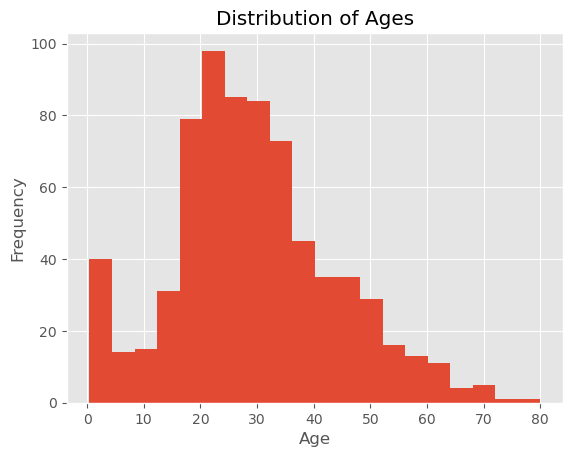

In [19]:
infer("Please plot the distribution of ages. Add lables to the figure and a suitable title too.")



> Entering new AgentExecutor chain...
 ```python
import matplotlib.pyplot as plt

# Convert the 'Sex' column to categorical data
df['Sex'] = df['Sex'].astype('category')

# Group the data by Sex and Survived, then count the number of occurrences
grouped = df.groupby(['Sex', 'Survived']).size().unstack(fill_value=0)

# Plot the distribution
grouped.plot(kind='bar', rot=0)

# Add labels and title
plt.xlabel('Survived')
plt.ylabel('Count')
plt.title('Distribution of Gender against Survival')
plt.legend(loc='upper left')

# Display the plot
plt.show()
```

> Finished chain.


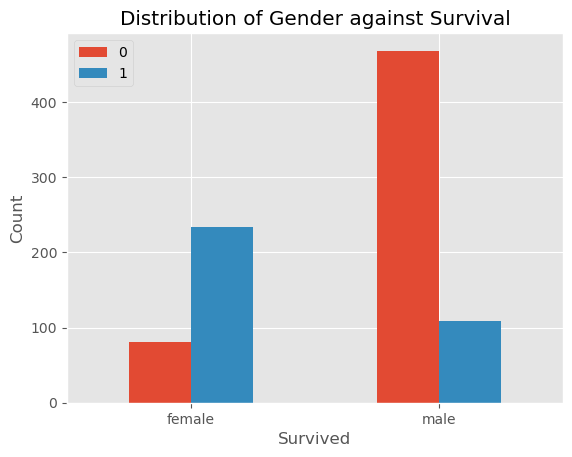

In [20]:
infer("Please plot the distribution of gender against survival. Add suitable labels and title.")

### This was a very complex prompt. Surprisingly, the model executed it very well!



> Entering new AgentExecutor chain...
 ```python
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Perform ordinal encoding on Embarked column
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Prepare the data for heatmap
corr_data = df[['Pclass', 'Age', 'Fare', 'Embarked', 'Survived']].corr()

# Generate the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, cmap="coolwarm")
plt.show()
```

> Finished chain.


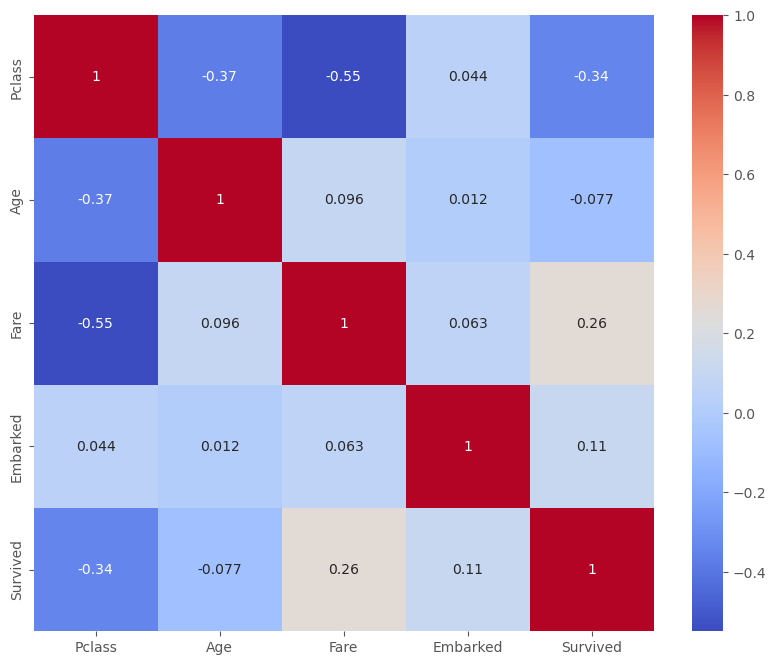

In [21]:
infer("Follow these steps:1. Perform ordinal encoding on Embarked column and 2. Now plot a heatmap of this transformed embarked along with PClass, Age and Fare against Survived. Do both 1 and 2")



> Entering new AgentExecutor chain...
 ```python
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x='Age', y='Fare', data=df)
plt.title('Regression Plot of Age against Fare')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.show()
```

> Finished chain.


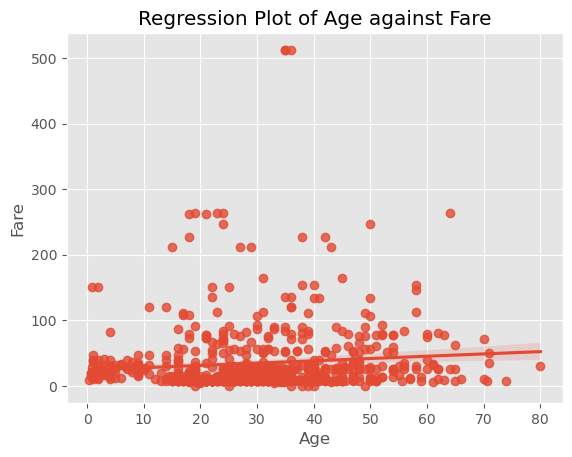

In [22]:
infer("Please plot a reg-plot of age against fair. Add a suitable title and labels.")

### The changed dataframe is being passed between inferences

In [23]:
infer("Print the unique values from the Embarked column")



> Entering new AgentExecutor chain...
 ```python
print(df['Embarked'].unique())
```

> Finished chain.
[ 0.  1.  2. nan]
